In [91]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)
pd.set_option('display.expand_frame_repr',False)
pd.set_option('display.max_colwidth',None)



In [93]:
#ipl data 23 and 24 only
deliveries = pd.read_csv('all_matches_updated.csv')


In [94]:
df = deliveries.copy()

In [95]:
df.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')

In [96]:
df = df.rename(columns={'ball':'balls'})
df = df.rename(columns={'over':'balls'})
df = df.rename(columns={'runs_off_bat':'batsman_runs'})
df = df.rename(columns={'innings':'inning'})
df['total_runs'] = df['batsman_runs'] + df['extras']

In [97]:
# Split the 'balls' column into 'over' and 'ball'
df[['over', 'ball']] = df['balls'].astype(str).str.split('.', expand=True)

# Convert to appropriate data types
df['over'] = df['over'].astype(int)
df['ball'] = df['ball'].astype(int)



In [98]:
wicket_types = [
    'caught', 'bowled', 'lbw', 'run out', 'stumped',
    'caught and bowled', 'retired hurt', 'hit wicket'
]

df['is_wicket'] = df['wicket_type'].apply(lambda x: 1 if x in wicket_types else 0)


In [99]:
df.head(1)

,match_id,season,start_date,venue,inning,balls,batting_team,bowling_team,striker,non_striker,bowler,batsman_runs,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,total_runs,over,ball,is_wicket
0,947091,2016,2016-05-20,Trent Bridge,1,0.1,Nottinghamshire,Warwickshire,MJ Lumb,MH Wessels,OJ Hannon-Dalby,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,0


In [111]:
import plotly.graph_objects as go
import pandas as pd

def analyze_phase_patterns(df, match_ids):
    df = df[df.match_id.isin(match_ids)]
    
    all_phase_data = []

    fig = go.Figure()

    for match_id in match_ids:
        df_match = df[df.match_id == match_id]
        df1 = df_match[df_match.inning == 1].reset_index(drop=True)
        df2 = df_match[df_match.inning == 2].reset_index(drop=True)

        df1['cum_runs'] = df1['total_runs'].cumsum()
        df2['cum_runs'] = df2['total_runs'].cumsum()

        df1['over_ball'] = df1['over'] + df1['ball'] / 10
        df2['over_ball'] = df2['over'] + df2['ball'] / 10

        df1['wicket'] = df1['is_wicket'].cumsum()
        df2['wicket'] = df2['is_wicket'].cumsum()

        def get_stats(df, start_over, end_over):
            df_filtered = df[(df['over_ball'] >= start_over) & (df['over_ball'] <= end_over)]
            if df_filtered.empty:
                return 0, 0
            return df_filtered['cum_runs'].iloc[-1] - df_filtered['cum_runs'].iloc[0], df_filtered['wicket'].iloc[-1] - df_filtered['wicket'].iloc[0]

        # Compute stats for each phase
        pp1_runs1, pp1_wickets1 = get_stats(df1, 0, 5.6)
        pp1_runs2, pp1_wickets2 = get_stats(df2, 0, 5.6)

        pp2_runs1, pp2_wickets1 = get_stats(df1, 5.7, 9.6)
        pp2_runs2, pp2_wickets2 = get_stats(df2, 5.7, 9.6)

        pp3_runs1, pp3_wickets1 = get_stats(df1, 9.7, 14.6)
        pp3_runs2, pp3_wickets2 = get_stats(df2, 9.7, 14.6)

        pp4_runs1, pp4_wickets1 = get_stats(df1, 14.7, df1['over_ball'].max())
        pp4_runs2, pp4_wickets2 = get_stats(df2, 14.7, df2['over_ball'].max())

        total_runs1, total_wickets1 = get_stats(df1, 0, df1['over_ball'].max())
        total_runs2, total_wickets2 = get_stats(df2, 0, df2['over_ball'].max())

        team1 = df1.batting_team.iloc[0]
        team2 = df2.batting_team.iloc[0]
        target = total_runs1 + 1  
        winner = team2 if total_runs2 >= target else team1  

        all_phase_data.append([match_id, team1, "Batting First", pp1_runs1, pp1_wickets1, pp2_runs1, pp2_wickets1, pp3_runs1, pp3_wickets1, pp4_runs1, pp4_wickets1, total_runs1, total_wickets1, winner])
        all_phase_data.append([match_id, team2, "Chasing", pp1_runs2, pp1_wickets2, pp2_runs2, pp2_wickets2, pp3_runs2, pp3_wickets2, pp4_runs2, pp4_wickets2, total_runs2, total_wickets2, winner])

        fig.add_trace(go.Scatter(x=df1['over_ball'], y=df1.cum_runs, mode='lines', name=f"{team1} - Match {match_id}", line=dict(width=2)))
        fig.add_trace(go.Scatter(x=df2['over_ball'], y=df2.cum_runs, mode='lines', name=f"{team2} - Match {match_id}", line=dict(width=2)))

    phase_df = pd.DataFrame(all_phase_data, columns=['Match_ID', 'Team', 'Inning Type', 'PP1_Runs', 'PP1_Wickets', 'PP2_Runs', 'PP2_Wickets', 'PP3_Runs', 'PP3_Wickets', 'PP4_Runs', 'PP4_Wickets', 'Total_Runs', 'Total_Wickets', 'Winner'])

    avg_winner = phase_df[phase_df['Team'] == phase_df['Winner']].mean(numeric_only=True)
    avg_loser = phase_df[phase_df['Team'] != phase_df['Winner']].mean(numeric_only=True)

    summary_text = (
        f"Winner Avg: PP1 {avg_winner['PP1_Runs']:.1f} runs / {avg_winner['PP1_Wickets']:.1f} wkts, "
        f"PP2 {avg_winner['PP2_Runs']:.1f} runs / {avg_winner['PP2_Wickets']:.1f} wkts, "
        f"PP3 {avg_winner['PP3_Runs']:.1f} runs / {avg_winner['PP3_Wickets']:.1f} wkts, "
        f"PP4 {avg_winner['PP4_Runs']:.1f} runs / {avg_winner['PP4_Wickets']:.1f} wkts\n"
        f"Loser Avg: PP1 {avg_loser['PP1_Runs']:.1f} runs / {avg_loser['PP1_Wickets']:.1f} wkts, "
        f"PP2 {avg_loser['PP2_Runs']:.1f} runs / {avg_loser['PP2_Wickets']:.1f} wkts, "
        f"PP3 {avg_loser['PP3_Runs']:.1f} runs / {avg_loser['PP3_Wickets']:.1f} wkts, "
        f"PP4 {avg_loser['PP4_Runs']:.1f} runs / {avg_loser['PP4_Wickets']:.1f} wkts"
    )

    fig.add_vrect(x0=0, x1=5.6, fillcolor="red", opacity=0.2, layer="below", line_width=0)
    fig.add_vrect(x0=5.7, x1=9.6, fillcolor="yellow", opacity=0.2, layer="below", line_width=0)
    fig.add_vrect(x0=9.7, x1=14.6, fillcolor="orange", opacity=0.2, layer="below", line_width=0)
    fig.add_vrect(x0=14.7, x1=20, fillcolor="green", opacity=0.2, layer="below", line_width=0)

    fig.add_annotation(x=2.5, y=phase_df['PP1_Runs'].max() * 0.9, text="PP1", showarrow=False, font=dict(size=12))
    fig.add_annotation(x=7.5, y=phase_df['PP2_Runs'].max() * 0.9, text="PP2", showarrow=False, font=dict(size=12))
    fig.add_annotation(x=12, y=phase_df['PP3_Runs'].max() * 0.9, text="PP3", showarrow=False, font=dict(size=12))
    fig.add_annotation(x=17, y=phase_df['PP4_Runs'].max() * 0.9, text="PP4", showarrow=False, font=dict(size=12))

    fig.add_annotation(
    text=summary_text,
    xref="paper", yref="paper",
    x=0.50, y=.95,  # Adjust position within the plot
    showarrow=False,
    font=dict(size=10.8,color="blue"),
    bordercolor="black",
    borderwidth=1,
    bgcolor="lightgray",
    align="left"  # Ensures text wraps properly
    )


    fig.update_layout(
        title="Multiple Matches - Runs Progression",
        xaxis_title='Overs',
        yaxis_title='Runs',
        template='plotly_dark',
        width=1100,
        height=600,
        legend=dict(x=0.02, y=-0.2, orientation="h", bgcolor="rgba(0,0,0,0.5)")
    )

    fig.show()
    return phase_df

# Example usage:
# phase_stats = analyze_phase_patterns(df, [match_id1, match_id2])


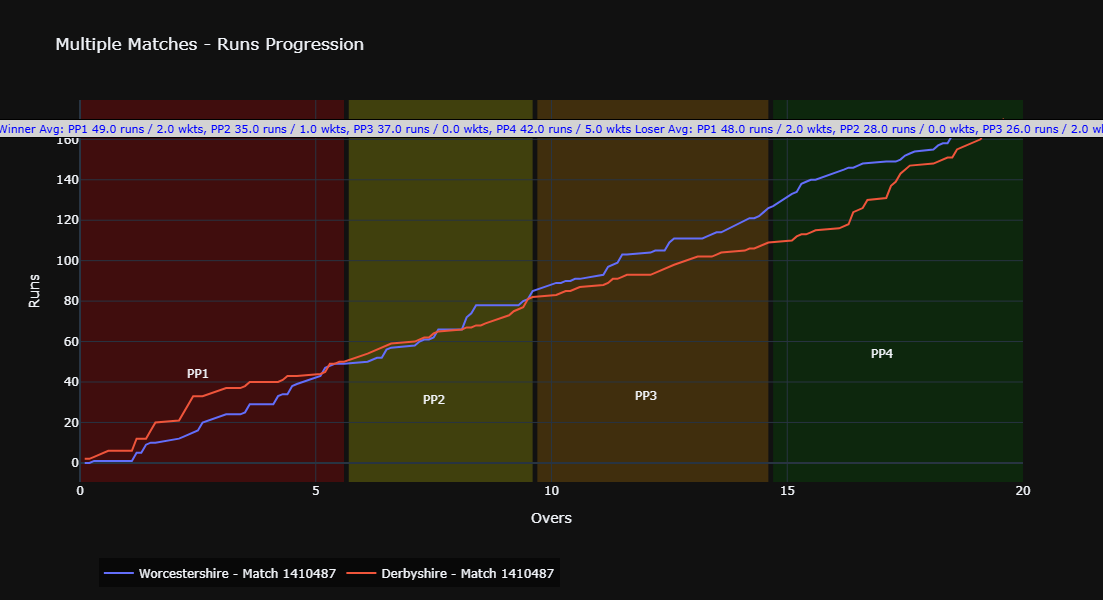

,Match_ID,Team,Inning Type,PP1_Runs,PP1_Wickets,PP2_Runs,PP2_Wickets,PP3_Runs,PP3_Wickets,PP4_Runs,PP4_Wickets,Total_Runs,Total_Wickets,Winner
0,1410487,Worcestershire,Batting First,49,2,35,1,37,0,42,5,169,8,Worcestershire
1,1410487,Derbyshire,Chasing,48,2,28,0,26,2,60,1,168,5,Worcestershire


In [113]:
#[1410463,1410480,1410487]
match_ids =[1410487]

analyze_phase_patterns(df, match_ids)


In [11]:
import pandas as pd
import plotly.graph_objects as go

def analyze_phase_patterns_with_dataframe(df, team_name):
    # First get all unique match IDs
    all_match_ids = df['match_id'].unique()
    
    # Filter to keep only matches where team_name participated
    teams_match_ids = []
    
    for match_id in all_match_ids:
        match_data = df[df['match_id'] == match_id]
        batting_teams = match_data['batting_team'].unique()
        if team_name in batting_teams:
            teams_match_ids.append(match_id)
    
    if not teams_match_ids:
        print(f"No matches found for team: {team_name}")
        return None
        
    # Continue with the rest of the function using these match IDs
    df = df[df.match_id.isin(teams_match_ids)]
    
    all_phase_data = []

    for match_id in teams_match_ids:
        df_match = df[df.match_id == match_id]
        df1 = df_match[df_match.inning == 1].reset_index(drop=True)
        df2 = df_match[df_match.inning == 2].reset_index(drop=True)

        # Skip incomplete matches
        if df1.empty or df2.empty:
            continue

        df1['cum_runs'] = df1['total_runs'].cumsum()
        df2['cum_runs'] = df2['total_runs'].cumsum()

        df1['over_ball'] = df1['over'] + df1['ball'] / 10
        df2['over_ball'] = df2['over'] + df2['ball'] / 10

        df1['wicket'] = df1['is_wicket'].cumsum()
        df2['wicket'] = df2['is_wicket'].cumsum()

        def get_stats(df, start_over, end_over):
            df_filtered = df[(df['over_ball'] >= start_over) & (df['over_ball'] <= end_over)]
            if df_filtered.empty:
                return 0, 0
            # Fix: Added [0] to access first element in the series
            return df_filtered['cum_runs'].iloc[-1] - df_filtered['cum_runs'].iloc[0], df_filtered['wicket'].iloc[-1] - df_filtered['wicket'].iloc[0]

        # Compute stats for each phase
        pp1_runs1, pp1_wickets1 = get_stats(df1, 0, 5.6)
        pp1_runs2, pp1_wickets2 = get_stats(df2, 0, 5.6)

        pp2_runs1, pp2_wickets1 = get_stats(df1, 5.7, 9.6)
        pp2_runs2, pp2_wickets2 = get_stats(df2, 5.7, 9.6)

        pp3_runs1, pp3_wickets1 = get_stats(df1, 9.7, 14.6)
        pp3_runs2, pp3_wickets2 = get_stats(df2, 9.7, 14.6)

        pp4_runs1, pp4_wickets1 = get_stats(df1, 14.7, df1['over_ball'].max())
        pp4_runs2, pp4_wickets2 = get_stats(df2, 14.7, df2['over_ball'].max())

        total_runs1, total_wickets1 = get_stats(df1, 0, df1['over_ball'].max())
        total_runs2, total_wickets2 = get_stats(df2, 0, df2['over_ball'].max())

        # Fix: Added [0] to access first team name in the series
        team1 = df1.batting_team.iloc[0]
        team2 = df2.batting_team.iloc[0]
        target = total_runs1 + 1  
        winner = team2 if total_runs2 >= target else team1
        loser = team1 if winner == team2 else team2

        # Append phase data for both innings
        all_phase_data.append([match_id, team1, "Batting First", pp1_runs1, pp1_wickets1, pp2_runs1, pp2_wickets1, pp3_runs1, pp3_wickets1, pp4_runs1, pp4_wickets1, total_runs1, total_wickets1, winner, loser])
        all_phase_data.append([match_id, team2, "Chasing", pp1_runs2, pp1_wickets2, pp2_runs2, pp2_wickets2, pp3_runs2, pp3_wickets2, pp4_runs2, pp4_wickets2, total_runs2, total_wickets2, winner, loser])

    # Create a DataFrame with all the phase data
    phase_df = pd.DataFrame(all_phase_data, columns=['Match_ID', 'Team', 'Inning Type', 'PP1_Runs', 'PP1_Wickets', 'PP2_Runs', 'PP2_Wickets', 'PP3_Runs', 'PP3_Wickets', 'PP4_Runs', 'PP4_Wickets', 'Total_Runs', 'Total_Wickets', 'Winner', 'Loser'])
    
    # Create a summary DataFrame with focus on match-by-match analysis
    match_summary = []
    for match_id in phase_df['Match_ID'].unique():
        match_data = phase_df[phase_df['Match_ID'] == match_id]
        
        if len(match_data) != 2:
            continue  # Skip incomplete matches
            
        team1_data = match_data.iloc[0]
        team2_data = match_data.iloc[1]
        
        match_summary.append({
            'Match_ID': match_id,
            'Team1': team1_data['Team'],
            'Team2': team2_data['Team'],
            'Team1_PP1_Runs': team1_data['PP1_Runs'],
            'Team1_PP1_Wickets': team1_data['PP1_Wickets'],
            'Team1_PP2_Runs': team1_data['PP2_Runs'],
            'Team1_PP2_Wickets': team1_data['PP2_Wickets'],
            'Team1_PP3_Runs': team1_data['PP3_Runs'],
            'Team1_PP3_Wickets': team1_data['PP3_Wickets'],
            'Team1_PP4_Runs': team1_data['PP4_Runs'],
            'Team1_PP4_Wickets': team1_data['PP4_Wickets'],
            'Team1_Total': team1_data['Total_Runs'],
            
            'Team2_PP1_Runs': team2_data['PP1_Runs'],
            'Team2_PP1_Wickets': team2_data['PP1_Wickets'],
            'Team2_PP2_Runs': team2_data['PP2_Runs'],
            'Team2_PP2_Wickets': team2_data['PP2_Wickets'],
            'Team2_PP3_Runs': team2_data['PP3_Runs'],
            'Team2_PP3_Wickets': team2_data['PP3_Wickets'],
            'Team2_PP4_Runs': team2_data['PP4_Runs'],
            'Team2_PP4_Wickets': team2_data['PP4_Wickets'],
            'Team2_Total': team2_data['Total_Runs'],
            
            'Winner': team1_data['Winner'],
            'Loser': team1_data['Loser']
        })
    
    match_summary_df = pd.DataFrame(match_summary)
    
    # Highlight matches where the selected team won
    match_summary_df['Selected_Team_Won'] = match_summary_df['Winner'] == team_name
    
    return {
        'detailed': phase_df,               # Detailed innings-by-innings DataFrame
        'summary': match_summary_df         # Match-by-match summary DataFrame
    }

# Example usage:
# result = analyze_phase_patterns_with_dataframe(df, "Chennai Super Kings")
# 
# # Display detailed DataFrame with all innings
# print(result['detailed'])
# 
# # Display match summary DataFrame
# print(result['summary'])


In [12]:
result = analyze_phase_patterns_with_dataframe(df, "Kent")
result['detailed'].tail(14)

,Match_ID,Team,Inning Type,PP1_Runs,PP1_Wickets,PP2_Runs,PP2_Wickets,PP3_Runs,PP3_Wickets,PP4_Runs,PP4_Wickets,Total_Runs,Total_Wickets,Winner,Loser
286,1410458,Surrey,Batting First,87,5,102,5,56,2,0,0,102,5,Surrey,Kent
287,1410458,Kent,Chasing,81,2,30,1,0,0,0,0,81,2,Surrey,Kent
288,1410461,Essex,Batting First,98,1,83,2,166,3,79,1,186,3,Essex,Kent
289,1410461,Kent,Chasing,164,5,37,1,152,5,63,3,164,5,Essex,Kent
290,1410468,Sussex,Batting First,106,4,58,2,136,1,135,2,202,4,Sussex,Kent
291,1410468,Kent,Chasing,111,10,79,7,54,7,6,1,111,10,Sussex,Kent
292,1410481,Glamorgan,Batting First,77,3,107,5,106,5,0,0,141,6,Glamorgan,Kent
293,1410481,Kent,Chasing,126,5,123,5,40,1,0,0,126,5,Glamorgan,Kent
294,1410491,Kent,Batting First,96,0,163,5,90,5,163,3,216,5,Kent,Surrey
295,1410491,Surrey,Chasing,71,2,127,9,57,8,6,2,131,10,Kent,Surrey


In [13]:
import pandas as pd
from IPython.display import display

def analyze_phase_patterns_with_dataframe(df, team_name, venue_name):
    # Get all unique match IDs
    all_match_ids = df['match_id'].unique()
    
    # Filter matches for team + venue
    teams_match_ids = []
    for match_id in all_match_ids:
        match_data = df[df['match_id'] == match_id]
        if match_data.empty:
            continue
            
        # Get first venue entry for the match
        venue = match_data['venue'].iloc[0]
        batting_teams = match_data['batting_team'].unique()
        
        if (team_name in batting_teams) and (venue == venue_name):
            teams_match_ids.append(match_id)
    
    if not teams_match_ids:
        print(f"No matches found for {team_name} at {venue_name}")
        # Return empty DataFrames instead of None
        return {
            'detailed': pd.DataFrame(),
            'summary': pd.DataFrame()
        }
    
    # Filter dataframe for relevant matches
    df = df[df.match_id.isin(teams_match_ids)]
    
    all_phase_data = []

    for match_id in teams_match_ids:
        df_match = df[df.match_id == match_id]
        df1 = df_match[df_match.inning == 1].reset_index(drop=True)
        df2 = df_match[df_match.inning == 2].reset_index(drop=True)

        # Skip incomplete matches
        if df1.empty or df2.empty:
            continue

        df1['cum_runs'] = df1['total_runs'].cumsum()
        df2['cum_runs'] = df2['total_runs'].cumsum()

        df1['over_ball'] = df1['over'] + df1['ball'] / 10
        df2['over_ball'] = df2['over'] + df2['ball'] / 10

        df1['wicket'] = df1['is_wicket'].cumsum()
        df2['wicket'] = df2['is_wicket'].cumsum()

        def get_stats(df, start_over, end_over):
            df_filtered = df[(df['over_ball'] >= start_over) & (df['over_ball'] <= end_over)]
            if df_filtered.empty:
                return 0, 0
            return df_filtered['cum_runs'].iloc[-1] - df_filtered['cum_runs'].iloc[0], df_filtered['wicket'].iloc[-1] - df_filtered['wicket'].iloc[0]

        # Compute stats for each phase
        pp1_runs1, pp1_wickets1 = get_stats(df1, 0, 5.6)
        pp1_runs2, pp1_wickets2 = get_stats(df2, 0, 5.6)

        pp2_runs1, pp2_wickets1 = get_stats(df1, 5.7, 9.6)
        pp2_runs2, pp2_wickets2 = get_stats(df2, 5.7, 9.6)

        pp3_runs1, pp3_wickets1 = get_stats(df1, 9.7, 14.6)
        pp3_runs2, pp3_wickets2 = get_stats(df2, 9.7, 14.6)

        pp4_runs1, pp4_wickets1 = get_stats(df1, 14.7, df1['over_ball'].max())
        pp4_runs2, pp4_wickets2 = get_stats(df2, 14.7, df2['over_ball'].max())

        total_runs1, total_wickets1 = get_stats(df1, 0, df1['over_ball'].max())
        total_runs2, total_wickets2 = get_stats(df2, 0, df2['over_ball'].max())

        team1 = df1.batting_team.iloc[0]
        team2 = df2.batting_team.iloc[0]
        target = total_runs1 + 1  
        winner = team2 if total_runs2 >= target else team1
        loser = team1 if winner == team2 else team2

        # Append phase data for both innings
        all_phase_data.append([match_id, team1, "Batting First", pp1_runs1, pp1_wickets1, pp2_runs1, pp2_wickets1, pp3_runs1, pp3_wickets1, pp4_runs1, pp4_wickets1, total_runs1, total_wickets1, winner, loser, venue_name])
        all_phase_data.append([match_id, team2, "Chasing", pp1_runs2, pp1_wickets2, pp2_runs2, pp2_wickets2, pp3_runs2, pp3_wickets2, pp4_runs2, pp4_wickets2, total_runs2, total_wickets2, winner, loser, venue_name])

    # Create a DataFrame with all the phase data
    phase_df = pd.DataFrame(
        all_phase_data, 
        columns=[
            'Match_ID', 'Team', 'Inning Type', 'PP1_Runs', 'PP1_Wickets', 'PP2_Runs', 'PP2_Wickets',
            'PP3_Runs', 'PP3_Wickets', 'PP4_Runs', 'PP4_Wickets', 'Total_Runs', 'Total_Wickets',
            'Winner', 'Loser', 'Venue'
        ]
    )
    
    # Create a summary DataFrame with focus on match-by-match analysis
    match_summary = []
    for match_id in phase_df['Match_ID'].unique():
        match_data = phase_df[phase_df['Match_ID'] == match_id]
        
        if len(match_data) != 2:
            continue  # Skip incomplete matches
            
        team1_data = match_data.iloc[0]
        team2_data = match_data.iloc[1]
        
        match_summary.append({
            'Match_ID': match_id,
            'Venue': venue_name,
            'Team1': team1_data['Team'],
            'Team2': team2_data['Team'],
            'Team1_PP1_Runs': team1_data['PP1_Runs'],
            'Team1_PP1_Wickets': team1_data['PP1_Wickets'],
            'Team1_PP2_Runs': team1_data['PP2_Runs'],
            'Team1_PP2_Wickets': team1_data['PP2_Wickets'],
            'Team1_PP3_Runs': team1_data['PP3_Runs'],
            'Team1_PP3_Wickets': team1_data['PP3_Wickets'],
            'Team1_PP4_Runs': team1_data['PP4_Runs'],
            'Team1_PP4_Wickets': team1_data['PP4_Wickets'],
            'Team1_Total': team1_data['Total_Runs'],
            
            'Team2_PP1_Runs': team2_data['PP1_Runs'],
            'Team2_PP1_Wickets': team2_data['PP1_Wickets'],
            'Team2_PP2_Runs': team2_data['PP2_Runs'],
            'Team2_PP2_Wickets': team2_data['PP2_Wickets'],
            'Team2_PP3_Runs': team2_data['PP3_Runs'],
            'Team2_PP3_Wickets': team2_data['PP3_Wickets'],
            'Team2_PP4_Runs': team2_data['PP4_Runs'],
            'Team2_PP4_Wickets': team2_data['PP4_Wickets'],
            'Team2_Total': team2_data['Total_Runs'],
            
            'Winner': team1_data['Winner'],
            'Loser': team1_data['Loser']
        })
    
    match_summary_df = pd.DataFrame(match_summary)
    
    # Highlight matches where the selected team won
    match_summary_df['Selected_Team_Won'] = match_summary_df['Winner'] == team_name
    
    return {
        'detailed': phase_df,               # Detailed innings-by-innings DataFrame
        'summary': match_summary_df         # Match-by-match summary DataFrame
    }


In [14]:

result = analyze_phase_patterns_with_dataframe(df, "Kent", "Kennington Oval, London")

if not result['detailed'].empty:
    display(result['detailed'].tail(14))   # Shows the last 14 rows as a table
    display(result['summary'])             # Shows the summary table
else:
    print("No data available for this team and venue combination.")


,Match_ID,Team,Inning Type,PP1_Runs,PP1_Wickets,PP2_Runs,PP2_Wickets,PP3_Runs,PP3_Wickets,PP4_Runs,PP4_Wickets,Total_Runs,Total_Wickets,Winner,Loser,Venue
0,1250340,Surrey,Batting First,26,2,84,2,84,3,128,7,128,7,Surrey,Kent,"Kennington Oval, London"
1,1250340,Kent,Chasing,41,0,104,1,83,1,5,0,128,1,Surrey,Kent,"Kennington Oval, London"
2,1297905,Kent,Batting First,95,2,140,3,183,5,160,3,191,5,Surrey,Kent,"Kennington Oval, London"
3,1297905,Surrey,Chasing,80,1,153,5,107,5,40,2,194,6,Surrey,Kent,"Kennington Oval, London"
4,1347575,Surrey,Batting First,67,4,148,4,144,1,166,4,220,5,Surrey,Kent,"Kennington Oval, London"
5,1347575,Kent,Chasing,175,7,105,1,70,6,37,2,181,7,Surrey,Kent,"Kennington Oval, London"
6,1410458,Surrey,Batting First,87,5,102,5,56,2,0,0,102,5,Surrey,Kent,"Kennington Oval, London"
7,1410458,Kent,Chasing,81,2,30,1,0,0,0,0,81,2,Surrey,Kent,"Kennington Oval, London"


,Match_ID,Venue,Team1,Team2,Team1_PP1_Runs,Team1_PP1_Wickets,Team1_PP2_Runs,Team1_PP2_Wickets,Team1_PP3_Runs,Team1_PP3_Wickets,Team1_PP4_Runs,Team1_PP4_Wickets,Team1_Total,Team2_PP1_Runs,Team2_PP1_Wickets,Team2_PP2_Runs,Team2_PP2_Wickets,Team2_PP3_Runs,Team2_PP3_Wickets,Team2_PP4_Runs,Team2_PP4_Wickets,Team2_Total,Winner,Loser,Selected_Team_Won
0,1250340,"Kennington Oval, London",Surrey,Kent,26,2,84,2,84,3,128,7,128,41,0,104,1,83,1,5,0,128,Surrey,Kent,False
1,1297905,"Kennington Oval, London",Kent,Surrey,95,2,140,3,183,5,160,3,191,80,1,153,5,107,5,40,2,194,Surrey,Kent,False
2,1347575,"Kennington Oval, London",Surrey,Kent,67,4,148,4,144,1,166,4,220,175,7,105,1,70,6,37,2,181,Surrey,Kent,False
3,1410458,"Kennington Oval, London",Surrey,Kent,87,5,102,5,56,2,0,0,102,81,2,30,1,0,0,0,0,81,Surrey,Kent,False


In [15]:
#filter by Venue match_id
venue_id= df[df['venue'] == "Old Trafford, Manchester"]['match_id'].unique()
print(venue_id)

[1250237 1250241 1250287 1250324 1250338 1250353 1269929 1297803 1297810
 1297822 1297831 1297914 1297922 1347573 1347583 1347648 1347671 1347688
 1347695 1410373 1410388 1410397 1410454 1410482 1410492 1460754 1460763
 1460772]


In [16]:
df.venue.unique()

array(['Trent Bridge', 'Headingley', 'Grace Road', 'Riverside Ground',
       'The Rose Bowl', "Lord's", 'Old Trafford',
       'The Cooper Associates County Ground', 'County Ground',
       "Merchant Taylors' School Ground", 'St Lawrence Ground',
       'Sophia Gardens', 'County Ground, New Road', 'Kennington Oval',
       'Arundel Castle Cricket Club Ground', 'Edgbaston', 'Old Deer Park',
       "Queen's Park", 'Castle Park Cricket Ground', 'College Ground',
       'The Kent County Cricket Ground', 'Uxbridge Cricket Club Ground',
       'Nevill Ground', 'Kent County Cricket Ground', 'Aigburth',
       'County Ground, Hove', 'Radlett Cricket Club',
       'St Lawrence Ground, Canterbury', 'Old Trafford, Manchester',
       'County Ground, New Road, Worcester',
       'The Cooper Associates County Ground, Taunton',
       'Headingley, Leeds', "Lord's, London", 'Sophia Gardens, Cardiff',
       'County Ground, Bristol', 'Riverside Ground, Chester-le-Street',
       'County Ground, Chelm

In [17]:
df.batting_team.unique()

array(['Lancashire', 'Nottinghamshire', 'Northamptonshire', 'Yorkshire',
       'Derbyshire', 'Leicestershire', 'Worcestershire', 'Durham',
       'Hampshire', 'Glamorgan', 'Essex', 'Middlesex', 'Sussex',
       'Somerset', 'Surrey', 'Kent', 'Gloucestershire', 'Warwickshire',
       'Birmingham Bears'], dtype=object)

In [18]:
common_matches = df[
    (df['batting_team'] ==  'Worcestershire') & 
    (df['bowling_team'] == 'Nottinghamshire')
]['match_id'].unique()

print(common_matches)


[ 693031  804527  804619  947191  947267 1068356 1068404 1127528 1127556
 1167128 1167257 1250238 1250293 1297807 1297915 1347608 1347666 1410392
 1410419]


In [19]:
import plotly.graph_objects as go
import pandas as pd

def analyze_phase_pattern(df, team_name):
    # First get all unique match IDs
    all_match_ids = df['match_id'].unique()
    
    # Filter to keep only matches where team_name participated
    teams_match_ids = []
    
    for match_id in all_match_ids:
        match_data = df[df['match_id'] == match_id]
        batting_teams = match_data['batting_team'].unique()
        if team_name in batting_teams:
            teams_match_ids.append(match_id)
    
    if not teams_match_ids:
        print(f"No matches found for team: {team_name}")
        return None
        
    # Continue with the rest of the function using these match IDs
    df = df[df.match_id.isin(teams_match_ids)]
    
    all_phase_data = []
    fig = go.Figure()

    for match_id in teams_match_ids:
        df_match = df[df.match_id == match_id]
        df1 = df_match[df_match.inning == 1].reset_index(drop=True)
        df2 = df_match[df_match.inning == 2].reset_index(drop=True)

        # Skip incomplete matches
        if df1.empty or df2.empty:
            continue

        df1['cum_runs'] = df1['total_runs'].cumsum()
        df2['cum_runs'] = df2['total_runs'].cumsum()

        df1['over_ball'] = df1['over'] + df1['ball'] / 10
        df2['over_ball'] = df2['over'] + df2['ball'] / 10

        df1['wicket'] = df1['is_wicket'].cumsum()
        df2['wicket'] = df2['is_wicket'].cumsum()

        def get_stats(df, start_over, end_over):
            df_filtered = df[(df['over_ball'] >= start_over) & (df['over_ball'] <= end_over)]
            if df_filtered.empty:
                return 0, 0
            return df_filtered['cum_runs'].iloc[-1] - df_filtered['cum_runs'].iloc[0], df_filtered['wicket'].iloc[-1] - df_filtered['wicket'].iloc[0]

        # Compute stats for each phase
        pp1_runs1, pp1_wickets1 = get_stats(df1, 0, 5.6)
        pp1_runs2, pp1_wickets2 = get_stats(df2, 0, 5.6)

        pp2_runs1, pp2_wickets1 = get_stats(df1, 5.7, 9.6)
        pp2_runs2, pp2_wickets2 = get_stats(df2, 5.7, 9.6)

        pp3_runs1, pp3_wickets1 = get_stats(df1, 9.7, 14.6)
        pp3_runs2, pp3_wickets2 = get_stats(df2, 9.7, 14.6)

        pp4_runs1, pp4_wickets1 = get_stats(df1, 14.7, df1['over_ball'].max())
        pp4_runs2, pp4_wickets2 = get_stats(df2, 14.7, df2['over_ball'].max())

        total_runs1, total_wickets1 = get_stats(df1, 0, df1['over_ball'].max())
        total_runs2, total_wickets2 = get_stats(df2, 0, df2['over_ball'].max())

        team1 = df1.batting_team.iloc[0]
        team2 = df2.batting_team.iloc[0]
        target = total_runs1 + 1  
        winner = team2 if total_runs2 >= target else team1  

        # Highlight the specified team in the visualization
        team1_color = "rgba(255, 0, 0, 1)" if team1 == team_name else "rgba(0, 0, 255, 0.7)"
        team2_color = "rgba(255, 0, 0, 1)" if team2 == team_name else "rgba(0, 0, 255, 0.7)"
        
        team1_width = 3 if team1 == team_name else 2
        team2_width = 3 if team2 == team_name else 2

        all_phase_data.append([match_id, team1, "Batting First", pp1_runs1, pp1_wickets1, pp2_runs1, pp2_wickets1, pp3_runs1, pp3_wickets1, pp4_runs1, pp4_wickets1, total_runs1, total_wickets1, winner])
        all_phase_data.append([match_id, team2, "Chasing", pp1_runs2, pp1_wickets2, pp2_runs2, pp2_wickets2, pp3_runs2, pp3_wickets2, pp4_runs2, pp4_wickets2, total_runs2, total_wickets2, winner])

        fig.add_trace(go.Scatter(x=df1['over_ball'], y=df1.cum_runs, mode='lines', name=f"{team1} - Match {match_id}", line=dict(width=team1_width, color=team1_color)))
        fig.add_trace(go.Scatter(x=df2['over_ball'], y=df2.cum_runs, mode='lines', name=f"{team2} - Match {match_id}", line=dict(width=team2_width, color=team2_color)))

    if not all_phase_data:
        print(f"No complete matches found for team: {team_name}")
        return None
        
    phase_df = pd.DataFrame(all_phase_data, columns=['Match_ID', 'Team', 'Inning Type', 'PP1_Runs', 'PP1_Wickets', 'PP2_Runs', 'PP2_Wickets', 'PP3_Runs', 'PP3_Wickets', 'PP4_Runs', 'PP4_Wickets', 'Total_Runs', 'Total_Wickets', 'Winner'])

    # Filter phase_df to focus on the specified team's performance
    team_phase_df = phase_df[phase_df['Team'] == team_name]
    
    # Calculate average metrics for when the team wins vs loses
    team_wins = team_phase_df[team_phase_df['Team'] == team_phase_df['Winner']]
    team_losses = team_phase_df[team_phase_df['Team'] != team_phase_df['Winner']]
    
    avg_team_win = team_wins.mean(numeric_only=True) if not team_wins.empty else pd.Series([0] * 10, index=['PP1_Runs', 'PP1_Wickets', 'PP2_Runs', 'PP2_Wickets', 'PP3_Runs', 'PP3_Wickets', 'PP4_Runs', 'PP4_Wickets', 'Total_Runs', 'Total_Wickets'])
    avg_team_loss = team_losses.mean(numeric_only=True) if not team_losses.empty else pd.Series([0] * 10, index=['PP1_Runs', 'PP1_Wickets', 'PP2_Runs', 'PP2_Wickets', 'PP3_Runs', 'PP3_Wickets', 'PP4_Runs', 'PP4_Wickets', 'Total_Runs', 'Total_Wickets'])
    
    win_rate = len(team_wins) / len(team_phase_df) * 100 if len(team_phase_df) > 0 else 0

    summary_text = (
        f"{team_name} Win Rate: {win_rate:.1f}% ({len(team_wins)} of {len(team_phase_df)} matches)\n"
        f"{team_name} When Winning: PP1 {avg_team_win['PP1_Runs']:.1f}r/{avg_team_win['PP1_Wickets']:.1f}w, "
        f"PP2 {avg_team_win['PP2_Runs']:.1f}r/{avg_team_win['PP2_Wickets']:.1f}w, "
        f"PP3 {avg_team_win['PP3_Runs']:.1f}r/{avg_team_win['PP3_Wickets']:.1f}w, "
        f"PP4 {avg_team_win['PP4_Runs']:.1f}r/{avg_team_win['PP4_Wickets']:.1f}w\n"
        f"{team_name} When Losing: PP1 {avg_team_loss['PP1_Runs']:.1f}r/{avg_team_loss['PP1_Wickets']:.1f}w, "
        f"PP2 {avg_team_loss['PP2_Runs']:.1f}r/{avg_team_loss['PP2_Wickets']:.1f}w, "
        f"PP3 {avg_team_loss['PP3_Runs']:.1f}r/{avg_team_loss['PP3_Wickets']:.1f}w, "
        f"PP4 {avg_team_loss['PP4_Runs']:.1f}r/{avg_team_loss['PP4_Wickets']:.1f}w"
    )

    fig.add_vrect(x0=0, x1=5.6, fillcolor="red", opacity=0.2, layer="below", line_width=0)
    fig.add_vrect(x0=5.7, x1=9.6, fillcolor="yellow", opacity=0.2, layer="below", line_width=0)
    fig.add_vrect(x0=9.7, x1=14.6, fillcolor="orange", opacity=0.2, layer="below", line_width=0)
    fig.add_vrect(x0=14.7, x1=20, fillcolor="green", opacity=0.2, layer="below", line_width=0)

    # Get max values for annotation positioning
    y_values = []
    for trace in fig.data:
        if hasattr(trace, 'y') and trace.y is not None:
            y_values.extend(trace.y)
    
    max_y = max(y_values) if y_values else 200
    
    fig.add_annotation(x=2.5, y=max_y * 0.2, text="PP1", showarrow=False, font=dict(size=12))
    fig.add_annotation(x=7.5, y=max_y * 0.2, text="PP2", showarrow=False, font=dict(size=12))
    fig.add_annotation(x=12, y=max_y * 0.2, text="PP3", showarrow=False, font=dict(size=12))
    fig.add_annotation(x=17, y=max_y * 0.2, text="PP4", showarrow=False, font=dict(size=12))

    fig.add_annotation(
        text=summary_text,
        xref="paper", yref="paper",
        x=0.50, y=.95,
        showarrow=False,
        font=dict(size=10.2),
        bordercolor="black",
        borderwidth=1,
        bgcolor="lightgray",
        align="left"
    )

    fig.update_layout(
        title=f"{team_name} - Performance Analysis Across {len(teams_match_ids)} Matches",
        xaxis_title='Overs',
        yaxis_title='Runs',
        template='plotly_dark',
        width=1100,
        height=600,
        legend=dict(x=0.02, y=-0.2, orientation="h", bgcolor="rgba(0,0,0,0.5)")
    )

    # Print team performance summary
    print(f"\n📊 {team_name} Performance Analysis 📊")
    print("="*50)
    print(f"🏏 Total Matches Analyzed: {len(team_phase_df)}")
    print(f"🏆 Matches Won: {len(team_wins)} ({win_rate:.1f}%)")
    print(f"💔 Matches Lost: {len(team_losses)}")
    print("\n⚡ Phase-wise Performance (Averages):")
    print("-----------------------------------")
    print("|   PP1   |   PP2   |   PP3   |   PP4   |  Total")
    print("| R | W  | R | W  | R | W  | R | W  | Runs | Wkts")
    print("-"*55)
    
    # Winning performance
    print(f"🏅 When Winning:")
    print(f"Runs  | {avg_team_win['PP1_Runs']:3.1f} | {avg_team_win['PP2_Runs']:3.1f} | {avg_team_win['PP3_Runs']:3.1f} | {avg_team_win['PP4_Runs']:3.1f} | {avg_team_win['Total_Runs']:5.1f}")
    print(f"Wkts  | {avg_team_win['PP1_Wickets']:3.1f} | {avg_team_win['PP2_Wickets']:3.1f} | {avg_team_win['PP3_Wickets']:3.1f} | {avg_team_win['PP4_Wickets']:3.1f} | {avg_team_win['Total_Wickets']:5.1f}")
    
    # Losing performance
    print(f"\n💥 When Losing:")
    print(f"Runs  | {avg_team_loss['PP1_Runs']:3.1f} | {avg_team_loss['PP2_Runs']:3.1f} | {avg_team_loss['PP3_Runs']:3.1f} | {avg_team_loss['PP4_Runs']:3.1f} | {avg_team_loss['Total_Runs']:5.1f}")
    print(f"Wkts  | {avg_team_loss['PP1_Wickets']:3.1f} | {avg_team_loss['PP2_Wickets']:3.1f} | {avg_team_loss['PP3_Wickets']:3.1f} | {avg_team_loss['PP4_Wickets']:3.1f} | {avg_team_loss['Total_Wickets']:5.1f}")
    
    # Print key metrics
    print("\n🔑 Key Metrics:")
    print(f"🎯 Highest Score: {team_phase_df['Total_Runs'].max():.0f}")
    print(f"📉 Lowest Score: {team_phase_df['Total_Runs'].min():.0f}")
    print(f"🏹 Best Bowling: {team_phase_df['Total_Wickets'].max()} wickets")
    print(f"⚡ Best Powerplay: {team_phase_df['PP1_Runs'].max():.0f} runs")
    
    # Print phase definitions
    print("\n📌 Phase Definitions:")
    print("PP1: Powerplay 1 (Overs 0.1-5.6)")
    print("PP2: Powerplay 2 (Overs 5.7-9.6)")
    print("PP3: Middle Overs (Overs 9.7-14.6)")
    print("PP4: Death Overs (Overs 14.7-20.0)")



In [20]:
phase_stats = analyze_phase_pattern(df,'Kent')


📊 Kent Performance Analysis 📊
🏏 Total Matches Analyzed: 150
🏆 Matches Won: 71 (47.3%)
💔 Matches Lost: 79

⚡ Phase-wise Performance (Averages):
-----------------------------------
|   PP1   |   PP2   |   PP3   |   PP4   |  Total
| R | W  | R | W  | R | W  | R | W  | Runs | Wkts
-------------------------------------------------------
🏅 When Winning:
Runs  | 88.4 | 103.5 | 95.8 | 102.0 | 175.8
Wkts  | 2.4 | 3.0 | 3.2 | 3.5 |   5.6

💥 When Losing:
Runs  | 96.4 | 89.6 | 88.1 | 67.8 | 151.0
Wkts  | 3.8 | 4.1 | 4.5 | 3.5 |   6.9

🔑 Key Metrics:
🎯 Highest Score: 232
📉 Lowest Score: 46
🏹 Best Bowling: 10 wickets
⚡ Best Powerplay: 226 runs

📌 Phase Definitions:
PP1: Powerplay 1 (Overs 0.1-5.6)
PP2: Powerplay 2 (Overs 5.7-9.6)
PP3: Middle Overs (Overs 9.7-14.6)
PP4: Death Overs (Overs 14.7-20.0)
